## Initialization - Required packages for 1st time

In [ ]:
#Install tensorflow examples
!pip install -q git+https://github.com/tensorflow/examples.git

    
#colab
#!pip install -q git+https://github.com/tensorflow/examples.git

#Mount drive
#from google.colab import drive
#drive.mount('/content/drive')

In [13]:
import tensorflow as tf
import numpy as np
import random
from tensorflow_examples.models.pix2pix import pix2pix
import pathlib
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
%matplotlib inline

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
#Network parameters
NETWORK_WIDTH = 400
NETWORK_HEIGHT = 400
TESTDATA_WIDTH = 608
TESTDATA_HEIGHT = 608
OUTPUT_CHANNELS = 2

## Dataset load and prepare

In [15]:
#Not to run everytime
#Zip neeeds to be in the jupyter folder
!rm -rf data
!mkdir data
!unzip -q "cil-road-segmentation-2020.zip" -d data

#If using Colab
#!unzip -q "/content/drive/My Drive/CIL_colab/toubi/data_compressed/cil-road-segmentation-2020.zip" -d data

## Import data in TF format

In [16]:
data_dir = pathlib.Path('.', 'data', 'training', 'training').resolve()
list_ds = tf.data.Dataset.list_files(str(data_dir/'images/*'))

In [17]:
def read_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.resize(img, (NETWORK_WIDTH, NETWORK_HEIGHT))
    img = tf.image.convert_image_dtype(img, tf.float32) # Cast and normalize the image to [0,1]
    img = tf.image.per_image_standardization(img)
    return img

def read_mask(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels = 1)
    img = tf.image.resize(img, (NETWORK_WIDTH, NETWORK_HEIGHT))
    img = tf.round(tf.cast(img, tf.float32) / 255.0)
    return img

def process_path(file_path):
    img = read_image(file_path)
    maskPath = tf.strings.regex_replace(file_path, 'images', 'groundtruth')
    mask = read_mask(maskPath)
    #tf.print(file_path)
    #tf.print(maskPath)
    return img, mask

def leftright(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask
def rot90(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask
def rot180(img, mask):
    img = tf.image.rot90(img, k=2)
    mask = tf.image.rot90(mask, k=2)
    return img, mask
def rot270(img, mask):
    img = tf.image.rot90(img, k=3)
    mask = tf.image.rot90(mask, k=3)
    return img, mask
def random_characteristics(img, mask):
    img = tf.image.random_brightness(img, max_delta=0.5)
    img = tf.image.random_contrast(img, 0.8, 1.3)
    img = tf.image.random_saturation(img, 0.8, 1.3)
    img = tf.image.random_hue(img, max_delta = 0.3)
    return img, mask

def add_gaussian_noise(img, mask):    
    noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=80/(255))
    #print(tf.shape(img))
    noise_img = img + noise
    return noise_img, mask

def extendDataSet(dataset):
    outset = dataset.map(leftright)
    outset = outset.concatenate(dataset.map(rot90))
    outset = outset.concatenate(dataset.map(add_gaussian_noise))
    outset = outset.concatenate(dataset.map(rot90).map(leftright))
    outset = outset.concatenate(dataset.map(rot180))
    outset = outset.concatenate(dataset.map(rot180).map(leftright))
    outset = outset.concatenate(dataset.map(rot270))
    outset = outset.concatenate(dataset.map(rot270).map(leftright))
    outset = outset.concatenate(dataset.map(add_gaussian_noise))

    outset = outset.map(random_characteristics)
    return outset

In [18]:
whole_ds = list_ds.map(process_path)

ds_size = len(list(whole_ds))
valid_count = int(ds_size*0.3)
valid_ds = whole_ds.take(valid_count)
train_ds = whole_ds.skip(valid_count)
train_ds = train_ds.concatenate(extendDataSet(train_ds))

TRAIN_LENGTH = len(list(train_ds))
BATCH_SIZE = 15 #20
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE // 4

#The datasets to train the model with. Copied from the example. Doesn't work without these operations
train_dataset = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_ds.batch(BATCH_SIZE)

## Have a look at an example datapoint

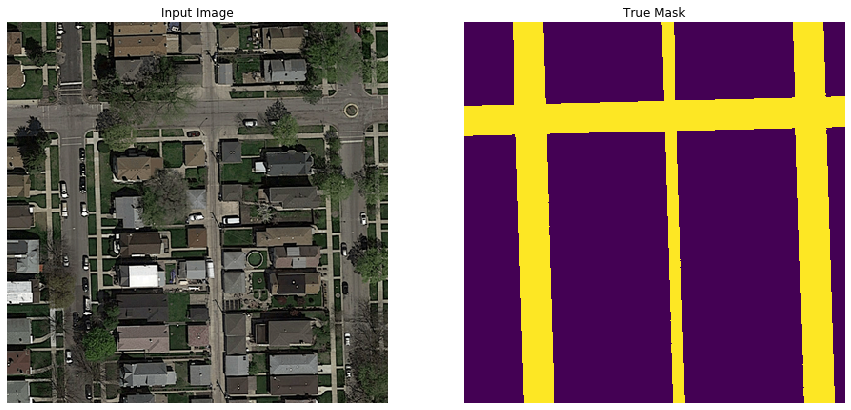

In [19]:
#take a look at the data
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

#Change take parameter to display a different datapoint
for image, mask in whole_ds.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

## Define the model
To accommodate for the training data picture size of 400x400 I modified the network from the example. Instead of 5 reductions, only 4 are used, because the last reduction would reduce the dimensions from 25x25 to 13x13 which cannot be upsampled afterwards. I wonder if that's the right solution, given that the test dataset then has a picture size of 400x400

## Downsampling

In [20]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[NETWORK_WIDTH, NETWORK_HEIGHT, 3], include_top=False)
base_model.trainable = False

# Use the activations of these layers

layer_names = [
    'block_1_expand_relu',   # 64x64 (None, 200, 200, 96)
    'block_3_expand_relu',   # 32x32 (None, 100, 100, 144)
    'block_6_expand_relu',   # 16x16 (None, 50, 50, 192)
    'block_13_expand_relu',  # 8x8 (None, 25, 25, 576)
    'block_16_project',      # 4x4 (None, 25, 25, 576)

]


layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False


In [21]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 401, 401, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 200, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 200, 200, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

## Upsampling

In [22]:
up_stack = [
    pix2pix.upsample(1024, 6,apply_dropout=True),  # 4x4 -> 8x8
    pix2pix.upsample(512, 5,apply_dropout=False),  # 8x8 -> 16x16
    pix2pix.upsample(256, 3,apply_dropout=True),  # 16x16 -> 32x32
#     pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

## Assemble the model

In [23]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[NETWORK_WIDTH, NETWORK_HEIGHT, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-2]
    skips = reversed(skips[:-2])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)
opt = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 200, 200, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50, 50, 1024) 21237760    model[1][3]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 50, 50, 1216) 0           sequential[0][0]                 
                                                                 model[1][2]                

## Have a look at it

In [25]:
#tf.keras.utils.plot_model(model, show_shapes=True)

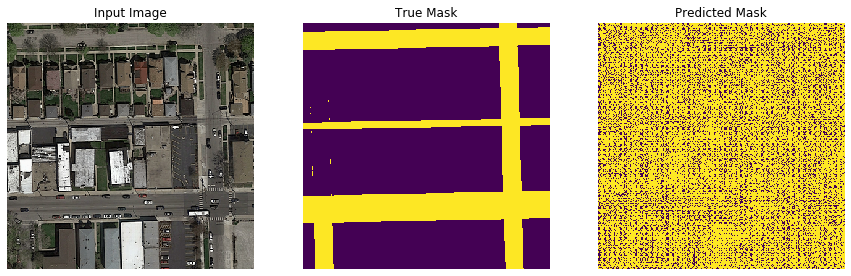

In [26]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
#Displays the predicted mask for the sample_image taken above, with random network parameters
show_predictions(valid_dataset)

## Train the model

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
EPOCHS = 40

#my_callbacks= [DisplayCallback(), tf.keras.callbacks.EarlyStopping(patience=9)]
my_callbacks= [DisplayCallback()]

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=my_callbacks)

### Have a look at the losses

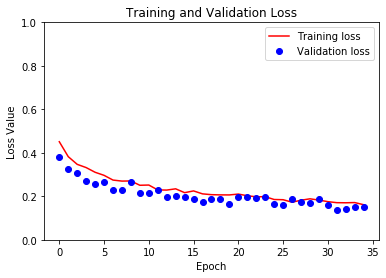

In [29]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(model_history.epoch))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Look at a prediction for the validation dataset

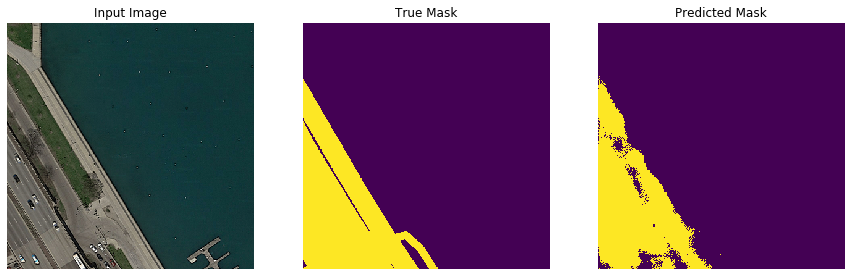

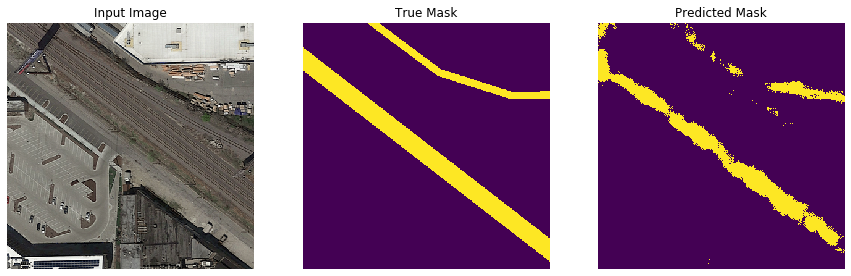

In [32]:
#Change number to look at a different datapoint
show_predictions(valid_dataset, 2)

### Evaluate and Save

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 200, 200, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50, 50, 1024) 21237760    model[1][3]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 50, 50, 1216) 0           sequential[0][0]                 
                                                                 model[1][2]                

In [34]:
!mkdir -p checkpoints
model.save_weights("checkpoints/.ckpt")

## Perform inference on actual test data
### Load & check model

In [35]:
latest = tf.train.latest_checkpoint("checkpoints")
latest

'checkpoints/.ckpt'

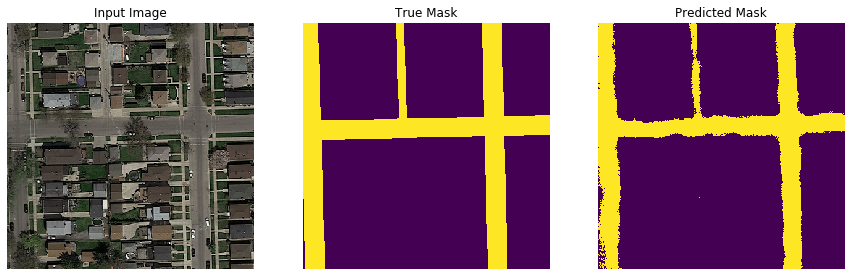

In [36]:
model.load_weights(latest)
show_predictions(valid_dataset, 1)

### Perform inference on test pictures

In [37]:
!rm -rf data/test_images/masks
!mkdir data/test_images/masks

In [38]:
data_dir = pathlib.Path('.', 'data', 'test_images').resolve()
list_ds = tf.data.Dataset.list_files(str(data_dir/'test_images/*'))

In [39]:
def read_image_inf(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels = 3)
    img = tf.image.resize(img, (TESTDATA_WIDTH, TESTDATA_HEIGHT))
    img = tf.image.convert_image_dtype(img, tf.float32) # Cast and normalize the image to [0,1]
    img = tf.image.per_image_standardization(img)
    return img

def infer_path(file_path):
    img = read_image_inf(file_path)
    img_topleft = tf.image.crop_to_bounding_box(img, 0, 0, NETWORK_WIDTH, NETWORK_HEIGHT)
    img_topright = tf.image.crop_to_bounding_box(img, TESTDATA_WIDTH - NETWORK_WIDTH, 0, NETWORK_WIDTH, NETWORK_HEIGHT)
    img_botleft = tf.image.crop_to_bounding_box(img, 0, TESTDATA_HEIGHT - NETWORK_HEIGHT, NETWORK_WIDTH, NETWORK_HEIGHT)
    img_botright = tf.image.crop_to_bounding_box(img, TESTDATA_WIDTH - NETWORK_WIDTH, TESTDATA_HEIGHT - NETWORK_HEIGHT, NETWORK_WIDTH, NETWORK_HEIGHT)
    mask_topleft = model.predict(img_topleft[tf.newaxis, ...])
    mask_topright = model.predict(img_topright[tf.newaxis, ...])
    mask_botleft = model.predict(img_botleft[tf.newaxis, ...])
    mask_botright = model.predict(img_botright[tf.newaxis, ...])
    mask_left = [tf.image.crop_to_bounding_box(mask_topleft, 0, 0, 304, 304),
                 tf.image.crop_to_bounding_box(mask_botleft, 0, NETWORK_HEIGHT - 304, 304, 304)]
    mask_left = tf.concat(mask_left, 2)
    mask_right = [tf.image.crop_to_bounding_box(mask_topright, NETWORK_WIDTH - 304, 0, 304, 304),
                 tf.image.crop_to_bounding_box(mask_botright, NETWORK_WIDTH - 304, NETWORK_HEIGHT - 304, 304, 304)]
    mask_right = tf.concat(mask_right, 2)
    pred_mask = tf.concat([mask_left, mask_right], 1)
    mask = create_mask(pred_mask)
    return img, mask

def infer_and_save(file_path, displayResults=False):
    img, mask = infer_path(file_path)
    mask_path = tf.strings.regex_replace(file_path, "test_images/test_images", "test_images/masks")
    mask_int = tf.cast(mask * 255, tf.uint8)
    mask_enc = tf.image.encode_png(mask_int)
    tf.io.write_file(mask_path, mask_enc)
    if displayResults:
        mask_read = read_mask(mask_path)
        display([img, mask, mask_read])

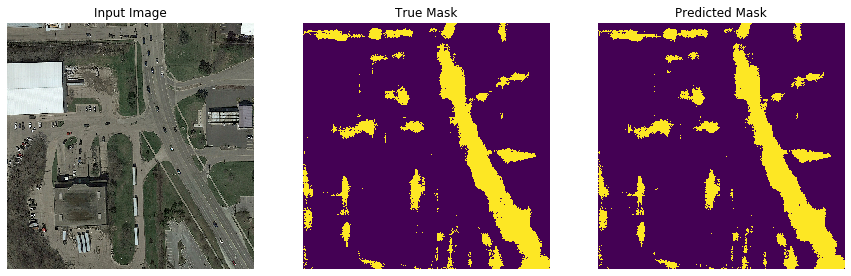

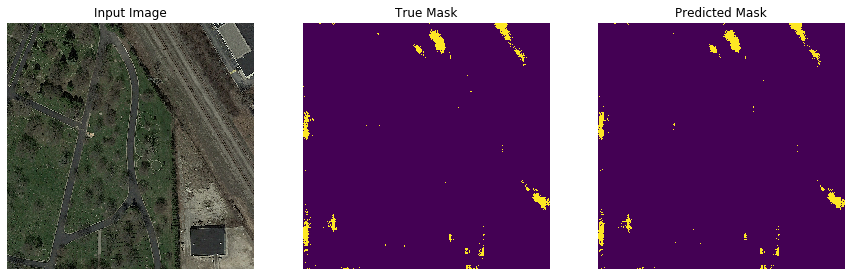

In [40]:
for idx, file_path in enumerate(list_ds):
    showResult = ((idx+1) % 40 == 0)
    infer_and_save(file_path, showResult)

## Create submission file

In [ ]:
#If you changed mask_to_submission.py
import importlib
importlib.reload(mask_to_submission)

In [41]:
import mask_to_submission
submission_filename = 'submissions/sub20.csv'
list_m = tf.data.Dataset.list_files(str(data_dir/'masks/*'))
posix_filenames = list(data_dir.glob('masks/*'))
image_filenames = []
for p in posix_filenames:
    image_filename = str(p)
#     print(image_filename)
    image_filenames.append(image_filename)
mask_to_submission.masks_to_submission(submission_filename, *image_filenames)